## XDF latency test analysis of LSL data streams: Unity (triggered) vs EEG (measured)
### __Description__:
Every 500 ms, a black image is displayed followed by a fixation cross, and finally a white image in a 3D canvas build with Unity engine. A coroutine is used as the controller of what gets displayed.
### Streams
#### __Unity: (90 FPS)__
- __Visual stream:__ Images changing from white, fixation cross, black using unity coroutines
#### __EEG (1024 Hz):__
- __Photodiode:__ a light sensitive sensor connected to the EEG recorder (channel 65) and placed on of the HMD to detect when images are displayed


In [1]:
import copy
import datetime
import itertools
import os

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from matplotlib.ticker import FormatStrFormatter

import pandas as pd
import pyxdf
import seaborn as sns
from scipy.signal import find_peaks
from tqdm.notebook import tqdm

In [2]:
files = os.listdir("lsl_coroutines_data")  # get all files from the folder "data"
files.sort()  # sort them alphabetically
recordings = {}
excluded = []
# for file in files:
#     # filter hidden/config files and folders
#     if not file.endswith(".xdf"):
#         files.remove(file)  # remove hidden/config file
#         excluded.append(file)  # add into excluded
#
#
# # short tests were excluded as they were too short and had strange statistics
# for e in excluded:
#     print(f"Excluded from '{e}/': {os.listdir(f'lsl_coroutines_data/{e}')}")

for i, file in enumerate(files):  # store and display all files
    created = os.path.getmtime(f"lsl_coroutines_data/{file}")  # creation timestamp
    created = datetime.datetime.fromtimestamp(created)  # translate as datetime
    created = created.strftime("%d.%m.%Y %H:%M")  # arrange it
    recordings[i] = {"file": file, "created": created}

files = [f.split(".")[0] for f in files]
print("Included:")
display(recordings)

Included:


{0: {'file': 'lsl_jtry_slack.xdf', 'created': '01.08.2022 21:13'},
 1: {'file': 'lsl_try1.xdf', 'created': '22.06.2022 15:26'},
 2: {'file': 'lsl_try1_new.xdf', 'created': '13.07.2022 22:44'},
 3: {'file': 'lsl_try1new_westdrive.xdf', 'created': '13.07.2022 23:18'},
 4: {'file': 'lsl_try2.xdf', 'created': '22.06.2022 16:18'},
 5: {'file': 'lsl_try3.xdf', 'created': '22.06.2022 16:25'},
 6: {'file': 'lsl_try4.xdf', 'created': '22.06.2022 17:35'},
 7: {'file': 'lsl_try5.xdf', 'created': '22.06.2022 19:11'},
 8: {'file': 'lsl_try6_noUpdate.xdf', 'created': '21.07.2022 23:41'}}

In [3]:
%matplotlib inline
# set pandas float display format
pd.options.display.float_format = "{:.5f}".format


def color_checks(val):
    if val == "✔":
        color = "green"
    elif val == "✗":
        color = "red"
    else:
        color = "blue"
    return "color: %s" % color


def correct_timestamps(ts):  # calculate time values from 0
    corrected = [0]
    length = len(ts)
    [corrected.append(ts[i + 1] - ts[0]) for i in range(length) if i < length - 1]
    return np.array(corrected)


def select_streams(streams):
    # stream names
    u_ch_name = "Visual"
    e_ch_name = "openvibeSignal"

    # get all current streams with their positions on the recording
    # example: {'Diode': 0, 'Audio': 1, 'openvibeSignal': 2}
    s_channels = {streams[i]["info"]["name"][0]: i for i in range(len(streams))}

    # store and return their positions
    u = s_channels[u_ch_name]
    # try:
    #     u = s_channels[u_ch_name]  # in case you multiple unity stream channels
    # except:
    #     u = s_channels["Visual"]  # in case you multiple unity stream channels
    e = s_channels[e_ch_name]  # eeg stream channel (diode and microphone)
    return u, e


def strip_plot(data, xticks, alpha=1):
    g = sns.stripplot(data=data, palette="muted", size=3, alpha=alpha)
    g.set_xticklabels(xticks)
    g.set_yticks(np.arange(0, g.get_ylim()[1], 0.001))
    plt.ylabel("Time (s)")
    plt.tight_layout()
    plt.show()

In [13]:
# progress bar format definitions
m_format = "{desc}:{bar}{percentage:3.0f}% {n_fmt}/{total_fmt} in {elapsed_s:.2f}s"
s_format = (
    "{desc}:{bar}{percentage:3.0f}% {n_fmt}/{total_fmt}{postfix} in {elapsed_s:.2f}s"
)
# main progress bar
main_bar = tqdm(
    recordings,
    desc="Processed",
    dynamic_ncols=True,
    mininterval=0.001,
    bar_format=m_format,
)
# check all files
for k in main_bar:
    file = recordings[k]["file"]  # current filename
    # current progress bar
    pbar = tqdm(
        range(7),
        desc=f"recordings[{k:2.0f}]",
        mininterval=0.001,
        maxinterval=1,
        bar_format=s_format,
    )

    pbar.set_postfix(file=file)
    # add unity and eeg entries
    recordings[k]["unity"] = {}
    recordings[k]["eeg"] = {}

    # 1. Load the XDF file
    postfix = {"step": "1. Load the XDF file", "file": file}
    pbar.set_postfix(postfix)
    streams, fileheader = pyxdf.load_xdf(f"lsl_coroutines_data/{file}")
    #here in streams we have the data, usually you will look at time_streams (sample at each timepoint) and time_stamps

    # display(streams)
    # select the data stream channels
    u_ch, e_ch = select_streams(streams)
    #so here you will get the number of the stream (e.g. 0-2)
    pbar.update(1) #progress bar


    # 2. Store selected stream info (only useful info)
    postfix = {"step": "2. Store selected stream info", "file": file}
    pbar.set_postfix(postfix)
    # keys to keep from streams[ch]["info"]
    i_keys = [
        "name",
        "type",
        "nominal_srate",
        "effective_srate",
        "created_at",
        "hostname",
    ]
    # keys to keep from streams[ch]["footer"]["info"]
    f_keys = ["first_timestamp", "last_timestamp", "sample_count"]
    # first add info dict for each stream
    recordings[k]["unity"] = {"info": {}}
    recordings[k]["eeg"] = {"info": {}}

    for key in i_keys:
        u_v = streams[u_ch]["info"][key]
        e_v = streams[e_ch]["info"][key]
        if type(u_v) == list and len(u_v) > 0:  # same for e_k, no need to check again
            # remove list format as 1-element lists
            u_v = u_v[0]
            e_v = e_v[0]
        recordings[k]["unity"]["info"][key] = u_v
        recordings[k]["eeg"]["info"][key] = e_v
    #
    for key in f_keys:
        u_v = streams[u_ch]["footer"]["info"][key]
        e_v = streams[e_ch]["footer"]["info"][key]
        if type(u_v) == list and len(u_v) > 0:
            u_v = u_v[0]
            e_v = e_v[0]
        recordings[k]["unity"]["info"][key] = u_v
        recordings[k]["eeg"]["info"][key] = e_v

    # display(recordings)
    # store if two computers were used (hostname comparison)
    u_host = recordings[k]["unity"]["info"]["hostname"]
    e_host = recordings[k]["eeg"]["info"]["hostname"]
    recordings[k]["two_computers"] = u_host != e_host
    pbar.update(1)

    # display(recordings)
    # store if two computers were used (hostname comparison)
    u_host = recordings[k]["unity"]["info"]["hostname"]
    e_host = recordings[k]["eeg"]["info"]["hostname"]
    recordings[k]["two_computers"] = u_host != e_host
    pbar.update(1)

    # 3. Store timestamps
    postfix = {"step": "3. Store timestamps", "file": file}
    pbar.set_postfix(postfix)
    streams[u_ch]["time_stamps"] = np.array(streams[u_ch]["time_stamps"])
    streams[e_ch]["time_stamps"] = np.array(streams[e_ch]["time_stamps"])
    recordings[k]["unity"]["time_stamps"] = streams[u_ch]["time_stamps"]
    recordings[k]["eeg"]["time_stamps"] = streams[e_ch]["time_stamps"]
    pbar.update(1)
    # display(recordings)

    # 4. Compare streams timestamps distance and order
    # store EEG received first (True/False)
    postfix = {"step": "4. Compare streams timestamps distance and order", "file": file}
    pbar.set_postfix(postfix)
    unity_first = streams[u_ch]["time_stamps"][0]
    eeg_first = streams[e_ch]["time_stamps"][0]
    time_diff = unity_first - eeg_first

    display(time_diff)
    # if diff bigger than eeg sample distance (0.98ms), something went wrong
    # bool cast needed, otherwise type is numpy bool
    recordings[k]["eeg_starts"] = bool(time_diff >= -0.00098)
    # if diff bigger than 1 second, timestamps are not aligned -> wrong recording
    recordings[k]["lsl_aligned"] = bool(time_diff < 1)
    pbar.update(1)

    # display(recordings[k]["eeg_starts"])
    # display(recordings[k]["lsl_aligned"])
    # 5. Correct and store timestamps
    postfix = {"step": "5. Correct and store timestamps", "file": file}
    pbar.set_postfix(postfix)

    u_corrected = correct_timestamps(streams[u_ch]["time_stamps"])
    e_corrected = correct_timestamps(streams[e_ch]["time_stamps"])

    # recorrect unity timestamps starting one of the streams at 0
    # shift values according to the diff: add diff to eeg or to unity
    ### ----- Unnecessary ? ----
    if time_diff < 0:
        e_corrected = np.array([i + abs(time_diff) for i in e_corrected])
    else:
        u_corrected = np.array([i + time_diff for i in u_corrected])
    # # store corrected timestamps (timestamps -> corrected, time_stamps -> original)
    recordings[k]["unity"]["timestamps"] = u_corrected
    recordings[k]["eeg"]["timestamps"] = e_corrected
    # display(u_corrected)
    # display(e_corrected)
    pbar.update(1)

     # 6. Store Unity values (audio playing and color changed)
    postfix = {"step": "6. Store Unity values", "file": file}
    pbar.set_postfix(postfix)
    # format: [currentFrame, value, timestamp] -> we store value
    unity_c = np.transpose(streams[u_ch]["time_series"])[1]
    recordings[k]["unity"]["Visual"] = unity_c.astype(int)
    pbar.update(1)
    #display(recordings)

    # 7. Select and store EEG values (microphone and photodiode)
    postfix = {"step": "7. Select and store EEG values", "file": file}
    pbar.set_postfix(postfix)
    # select microphone and diode values
    eeg = np.transpose(streams[e_ch]["time_series"])


    # diode data can be on channels 65 and 66, select the right one
    eeg_color = eeg[64] if max(eeg[64]) != 0.0 else eeg[65] #this is now checking for the data of the photodiode, we have placed it in 65 so we need to look at 64
    eeg_color = -eeg_color  # invert diode data polarity, easier to visualize

    # store them
    recordings[k]["eeg"]["Visual"] = eeg_color
    #display(recordings)

    # store if first and last timestamps coincide with file info
    # also if length of values and timestamps coincide
    for stream in ["unity", "eeg"]:
        # timestamps check
        o_first = recordings[k][stream]["time_stamps"][0]
        i_first = recordings[k][stream]["info"]["first_timestamp"]
        o_last = recordings[k][stream]["time_stamps"][-1]
        i_last = recordings[k][stream]["info"]["last_timestamp"]
        recordings[k][f"{stream}_first"] = float(o_first) == float(i_first)
        recordings[k][f"{stream}_last"] = float(o_last) == float(i_last)
        # length check
        l_time = len(recordings[k][stream]["time_stamps"])
        for ch in ["Visual"]:
            key = f"length_{stream}_{ch}"
            recordings[k][key] = l_time == len(recordings[k][stream][ch])
    pbar.update(1)
    #display(recordings)
    pbar.set_postfix(file=file)
    pbar.close()  # .clear() to hide the bar if leave=False on constructor

Processed:            0% 0/9 in 0.01s

recordings[ 0]:            0% 0/7 in 0.01s

0.23919924348592758

recordings[ 1]:            0% 0/7 in 0.01s

0.2351009997073561

recordings[ 2]:            0% 0/7 in 0.01s

0.2313018716431543

recordings[ 3]:            0% 0/7 in 0.01s

0.23108328763919417

recordings[ 4]:            0% 0/7 in 0.01s

0.279950609896332

recordings[ 5]:            0% 0/7 in 0.01s

0.2982455318560824

recordings[ 6]:            0% 0/7 in 0.01s

0.2880838247947395

recordings[ 7]:            0% 0/7 in 0.02s

0.23393928783480078

recordings[ 8]:            0% 0/7 in 0.01s

0.25864416384138167

In [24]:
recordings[0]

{'file': 'lsl_jtry_slack.xdf',
 'created': '01.08.2022 21:13',
 'unity': {'info': {'name': 'Visual',
   'type': 'Marker',
   'nominal_srate': '0.000000000000000',
   'effective_srate': 0,
   'created_at': '6325.206657400000',
   'hostname': 'ml03',
   'first_timestamp': '6463.9353385',
   'last_timestamp': '6674.9289639',
   'sample_count': '18990'},
  'time_stamps': array([1710344.13558686, 1710344.14675602, 1710344.15773337, ...,
         1710555.10797895, 1710555.11900731, 1710555.13030047]),
  'timestamps': array([  0.23919924,   0.2503684 ,   0.26134576, ..., 211.21159134,
         211.22261969, 211.23391285]),
  'Visual': array([2, 2, 2, ..., 2, 2, 2])},
 'eeg': {'info': {'name': 'openvibeSignal',
   'type': 'signal',
   'nominal_srate': '1024.000000000000',
   'effective_srate': 1024.0000082541621,
   'created_at': '1710122.680499000',
   'hostname': 'wd-left',
   'first_timestamp': '1710343.896405766',
   'last_timestamp': '1710554.926679766',
   'sample_count': '216095'},
  't

__Display recording Length__

In [25]:
r_length = {}
for k in recordings:
    file = recordings[k]["file"]
    l = len(recordings[k]["unity"]["timestamps"])
    ul = recordings[k]["unity"]["timestamps"][-1] / 60
    r_length[file] = ul

r_length

{'lsl_jtry_slack.xdf': 3.520565214171074,
 'lsl_try1.xdf': 2.7704407984449064,
 'lsl_try1_new.xdf': 6.412092563727038,
 'lsl_try1new_westdrive.xdf': 6.995541517876215,
 'lsl_try2.xdf': 10.387935184916326,
 'lsl_try3.xdf': 6.021511184480429,
 'lsl_try4.xdf': 32.013114150299224,
 'lsl_try5.xdf': 63.728807777311886,
 'lsl_try6_noUpdate.xdf': 4.537655965211646}

__Display FPS__

In [26]:
r_fps = {}
for k in recordings:
    file = recordings[k]["file"]
    l = len(recordings[k]["unity"]["timestamps"])
    ul = r_length[file]
    r_fps[file] = 1 / (ul * 60 / l)

r_fps

{'lsl_jtry_slack.xdf': 89.90507131997306,
 'lsl_try1.xdf': 89.87739429038432,
 'lsl_try1_new.xdf': 89.9472355191272,
 'lsl_try1new_westdrive.xdf': 89.95253120271761,
 'lsl_try2.xdf': 89.96173445745215,
 'lsl_try3.xdf': 89.9303596848491,
 'lsl_try4.xdf': 89.98708008042198,
 'lsl_try5.xdf': 89.99462252676581,
 'lsl_try6_noUpdate.xdf': 89.91793776230806}

__How do the recordings look like__

In [27]:
bool_keys = [k for k, v in recordings[0].items() if type(v) is bool]
bool_keys.sort()
checks = pd.DataFrame()
for k in recordings:
    file = recordings[k]["file"].split(".")[0]  # remove extension from filename
    current = {}
    current["created"] = recordings[k]["created"]
    for bool_k in bool_keys:
        current[bool_k] = "✔" if recordings[k][bool_k] else "✗"
    current["computers"] = recordings[k]["unity"]["info"]["hostname"]
    if recordings[k]["two_computers"]:
        current["computers"] += f" & {recordings[k]['eeg']['info']['hostname']}"
    current["duration (')"] = f"{r_length[recordings[k]['file']]:.2f}"
    current["FPS"] = f"{r_fps[recordings[k]['file']]:.3f}"
    check = pd.DataFrame.from_dict(current, orient="index", columns=[file])
    if checks.empty:  # first file
        checks = check
    else:
        checks = pd.merge(checks, check, left_index=True, right_index=True)

checks = checks.T  # transpose
display(checks.style.applymap(color_checks))

,created,eeg_first,eeg_last,eeg_starts,length_eeg_Visual,length_unity_Visual,lsl_aligned,two_computers,unity_first,unity_last,computers,duration ('),FPS
lsl_jtry_slack,01.08.2022 21:13,✗,✗,✔,✔,✔,✔,✔,✗,✗,ml03 & wd-left,3.52,89.905
lsl_try1,22.06.2022 15:26,✗,✗,✔,✔,✔,✔,✔,✗,✗,ml03 & wd-left,2.77,89.877
lsl_try1_new,13.07.2022 22:44,✗,✗,✔,✔,✔,✔,✔,✗,✗,ml03 & wd-left,6.41,89.947
lsl_try1new_westdrive,13.07.2022 23:18,✗,✗,✔,✔,✔,✔,✔,✗,✗,ml03 & wd-left,7.00,89.953
lsl_try2,22.06.2022 16:18,✗,✗,✔,✔,✔,✔,✔,✗,✗,ml03 & wd-left,10.39,89.962
lsl_try3,22.06.2022 16:25,✗,✗,✔,✔,✔,✔,✔,✗,✗,ml03 & wd-left,6.02,89.930
lsl_try4,22.06.2022 17:35,✗,✗,✔,✔,✔,✔,✔,✗,✗,ml03 & wd-left,32.01,89.987
lsl_try5,22.06.2022 19:11,✗,✗,✔,✔,✔,✔,✔,✗,✗,ml03 & wd-left,63.73,89.995
lsl_try6_noUpdate,21.07.2022 23:41,✗,✗,✔,✔,✔,✔,✔,✗,✗,ml03 & wd-left,4.54,89.918


In [29]:
checks = checks.sort_index()
display(
    checks.drop(
        columns=[
            "eeg_first",
            "eeg_last",
            "eeg_starts",
            # "length_unity_color",
            "lsl_aligned",
            "unity_first",
            "unity_last",
            # "length_eeg_color",
        ]
    ).style.applymap(color_checks)
)

,created,length_eeg_Visual,length_unity_Visual,two_computers,computers,duration ('),FPS
lsl_jtry_slack,01.08.2022 21:13,✔,✔,✔,ml03 & wd-left,3.52,89.905
lsl_try1,22.06.2022 15:26,✔,✔,✔,ml03 & wd-left,2.77,89.877
lsl_try1_new,13.07.2022 22:44,✔,✔,✔,ml03 & wd-left,6.41,89.947
lsl_try1new_westdrive,13.07.2022 23:18,✔,✔,✔,ml03 & wd-left,7.00,89.953
lsl_try2,22.06.2022 16:18,✔,✔,✔,ml03 & wd-left,10.39,89.962
lsl_try3,22.06.2022 16:25,✔,✔,✔,ml03 & wd-left,6.02,89.930
lsl_try4,22.06.2022 17:35,✔,✔,✔,ml03 & wd-left,32.01,89.987
lsl_try5,22.06.2022 19:11,✔,✔,✔,ml03 & wd-left,63.73,89.995
lsl_try6_noUpdate,21.07.2022 23:41,✔,✔,✔,ml03 & wd-left,4.54,89.918


__Display FPS__

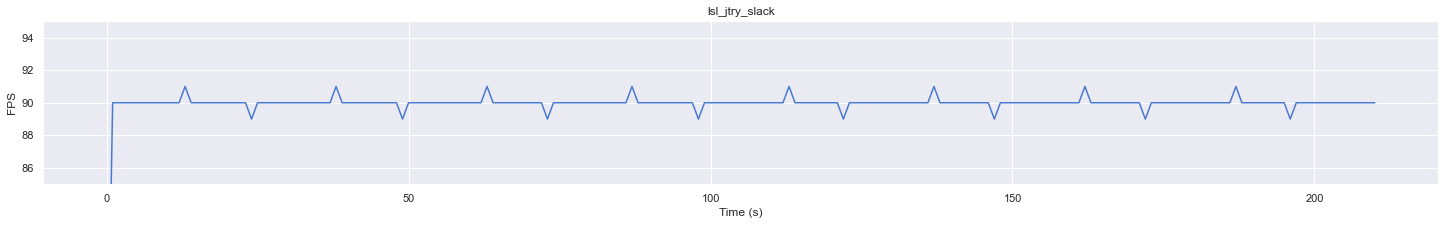

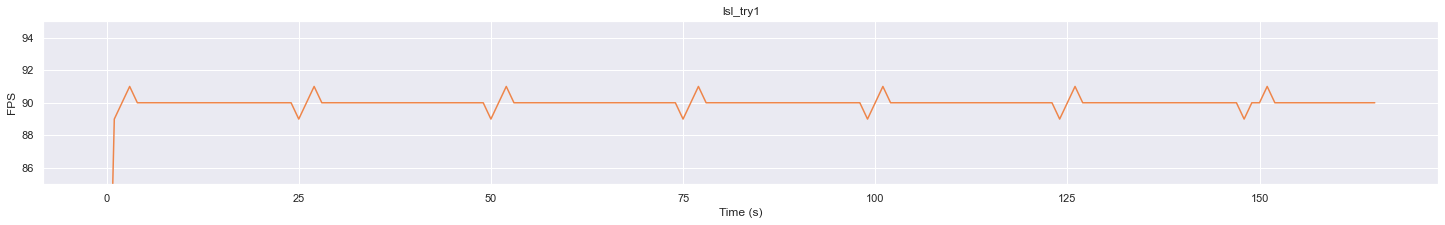

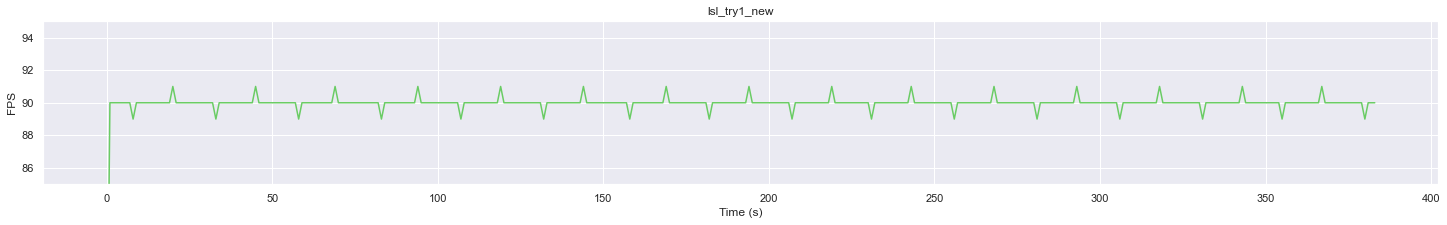

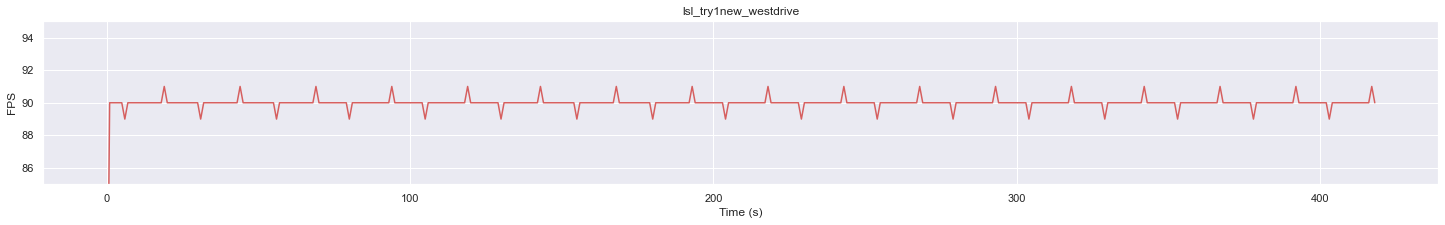

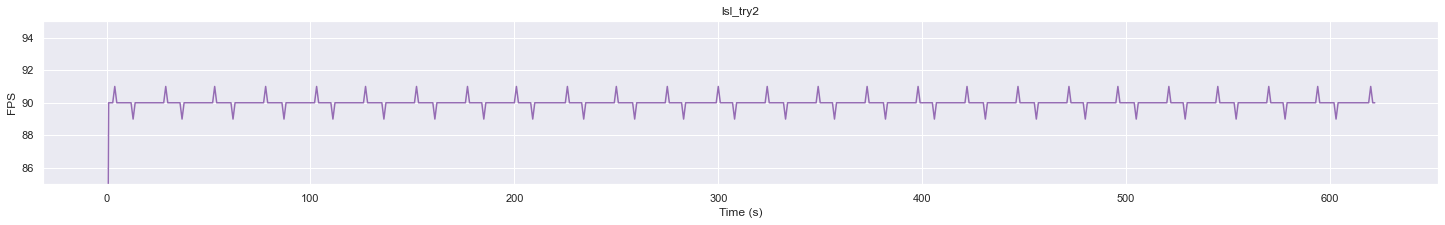

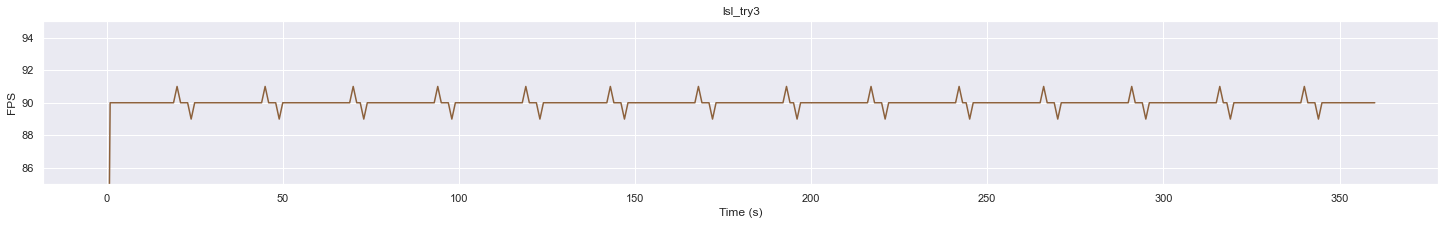

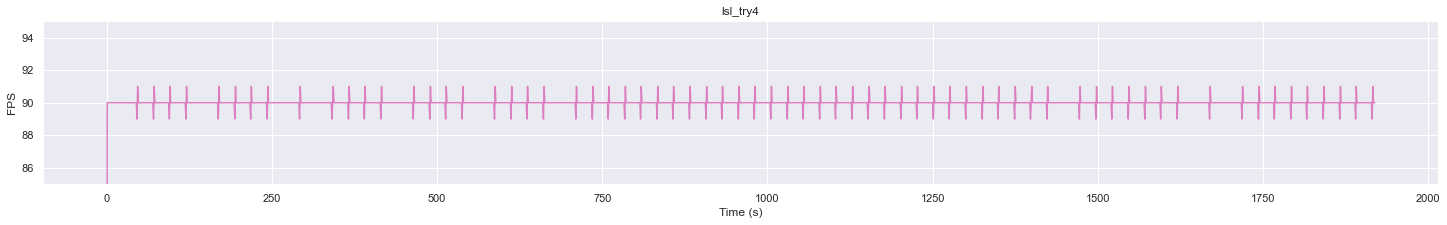

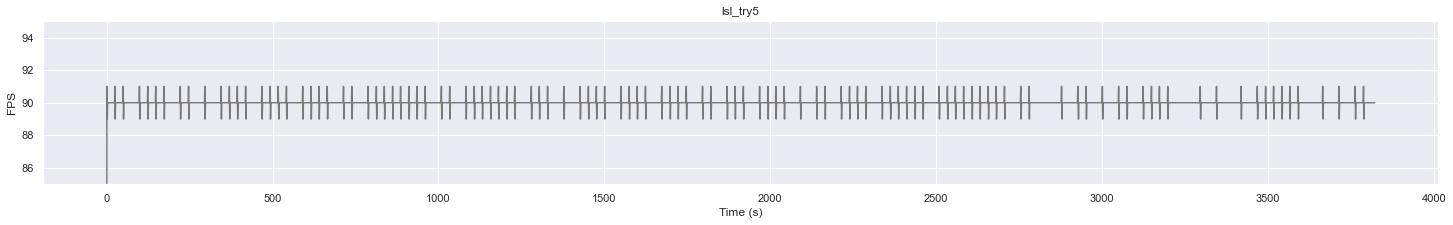

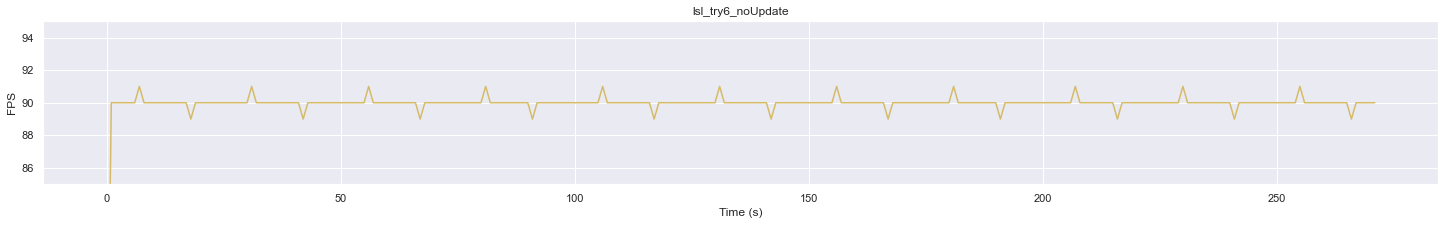

In [30]:
%matplotlib inline
sns.set_style("darkgrid")  # set seaborn plotting style
palette = itertools.cycle(sns.color_palette(palette="muted"))
for k in recordings:
    avg_fps = []
    temp = []
    next_sec = 1
    file = recordings[k]["file"].split(".")[0]
    for t in recordings[k]["unity"]["timestamps"]:
        if t <= next_sec:
            temp.append(t)
        else:
            avg_fps.append(len(temp))
            temp = []
            temp.append(t)
            next_sec += 1
    x = [i for i in range(len(avg_fps))]
    plt.figure(figsize=(25, 3))
    plt.title(file)
    plt.xlabel("Time (s)")
    plt.ylabel("FPS")
    sns.lineplot(x=x, y=avg_fps, color=next(palette))
    plt.ylim([85,95])
plt.show()

#### __Descriptive statistics: Unity and EEG samples time distance__

In [31]:
u_stats = pd.DataFrame()  # create empty dataframe
u_dist = []
e_dist = []
for k in recordings:
    file = recordings[k]["file"].split(".")[0]  # remove extension from filename
    # corrected timestamps
    u_ts = recordings[k]["unity"]["timestamps"]
    e_ts = recordings[k]["eeg"]["timestamps"]
    # compute the time distance between samples
    u = [u_ts[i + 1] - u_ts[i] for i in range(len(u_ts) - 1)]
    e = [e_ts[i + 1] - e_ts[i] for i in range(len(e_ts) - 1)]
    u_dist.append(u)
    e_dist.append(e)
    # store as dataframe (easier to compute descriptive statistics)
    u = pd.DataFrame(np.array(u), columns=[file])
    e = pd.DataFrame(np.array(e), columns=[file])
    if u_stats.empty:  # first file
        u_stats = u.describe()
        e_stats = e.describe()
    else:  # after first file, merge current stats with previous acumulated stats
        u_stats = pd.merge(u_stats, u.describe(), left_index=True, right_index=True)
        e_stats = pd.merge(e_stats, e.describe(), left_index=True, right_index=True)

u_mean = pd.DataFrame(u_stats.mean(axis=1), columns=["AVG"])
e_mean = pd.DataFrame(e_stats.mean(axis=1), columns=["AVG"])
u_stats = pd.merge(u_stats, u_mean, left_index=True, right_index=True)
e_stats = pd.merge(e_stats, e_mean, left_index=True, right_index=True)

In [32]:
display(u_stats.style.applymap(color_checks, subset=["AVG"]))

,lsl_jtry_slack,lsl_try1,lsl_try1_new,lsl_try1new_westdrive,lsl_try2,lsl_try3,lsl_try4,lsl_try5,lsl_try6_noUpdate,AVG
count,18990.000000,14939.000000,34604.000000,37755.000000,56070.000000,32490.000000,172845.000000,344114.000000,24480.000000,81809.666667
mean,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111
std,0.000848,0.000893,0.000846,0.000865,0.000796,0.000803,0.000759,0.000811,0.000823,0.000827
min,0.000154,0.000150,0.000151,0.000157,0.000152,0.000153,0.000150,0.000097,0.000152,0.000146
25%,0.011055,0.011062,0.011064,0.011064,0.011064,0.011063,0.011067,0.011058,0.011063,0.011062
50%,0.011102,0.011104,0.011103,0.011103,0.011104,0.011104,0.011104,0.011103,0.011104,0.011103
75%,0.011152,0.011146,0.011143,0.011143,0.011143,0.011144,0.011141,0.011149,0.011144,0.011145
max,0.022246,0.022415,0.022373,0.022459,0.022441,0.023078,0.022752,0.023023,0.022368,0.022573


In [33]:
display(e_stats.style.applymap(color_checks, subset=["AVG"]))

,lsl_jtry_slack,lsl_try1,lsl_try1_new,lsl_try1new_westdrive,lsl_try2,lsl_try3,lsl_try4,lsl_try5,lsl_try6_noUpdate,AVG
count,216095.000000,170015.000000,393727.000000,429567.000000,637951.000000,369663.000000,1966559.000000,3915199.000000,278527.000000,930811.444444
mean,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977
std,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
min,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977
25%,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977
50%,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977
75%,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977
max,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977


#### __Time distribution plots__

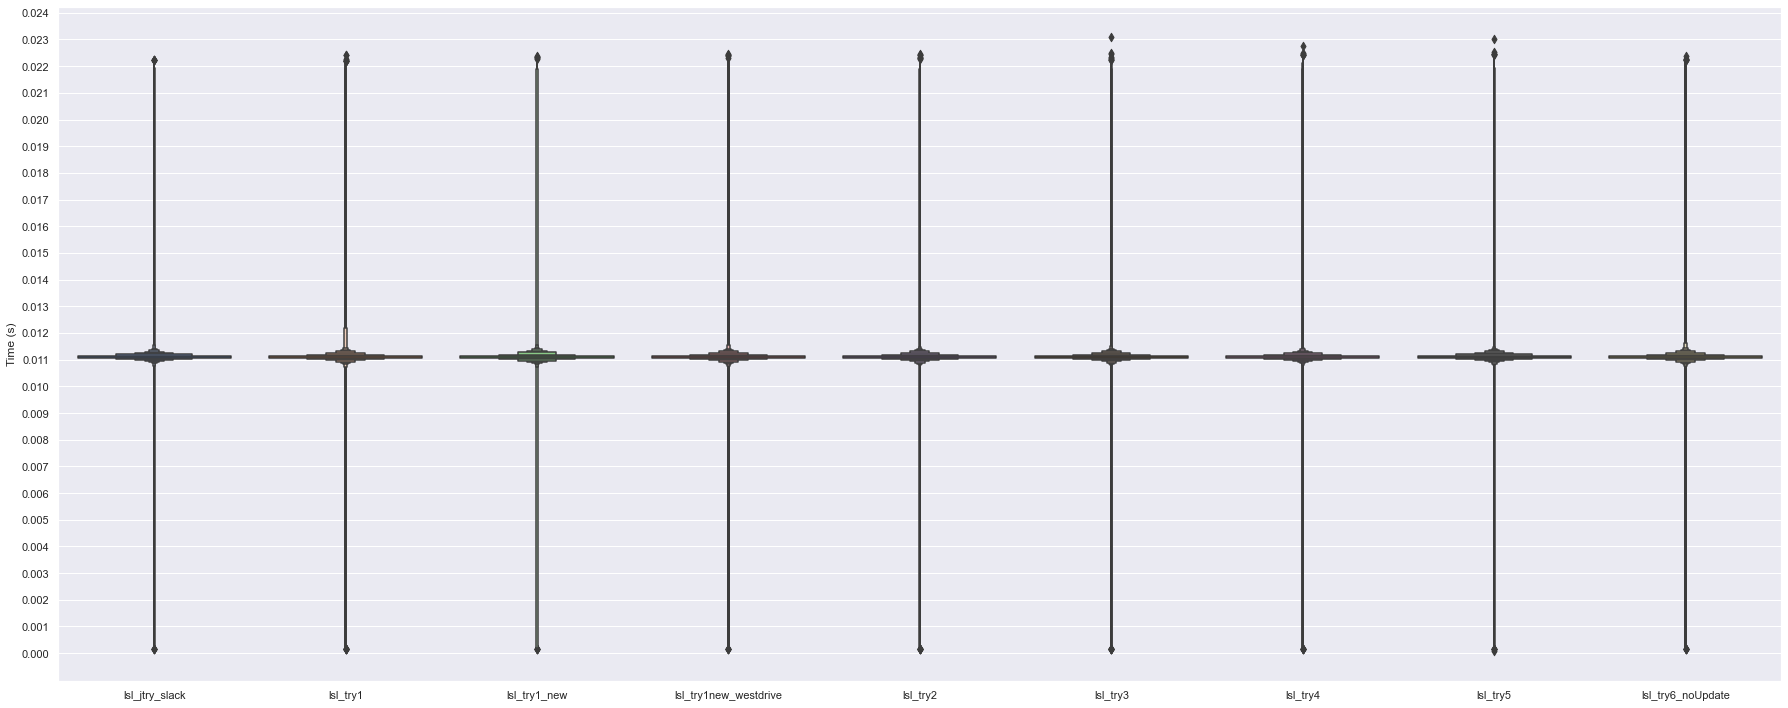

In [34]:
sns.set(rc={"figure.figsize": (25, 10)})  # set figure size
sns.set_style("darkgrid")  # set seaborn plotting style
g = sns.boxenplot(data=u_dist, palette="muted")
g.set_xticklabels(files)
g.set_yticks(np.arange(0, g.get_ylim()[1], 0.001))
plt.ticklabel_format(style="plain", axis="y", useOffset=False)
plt.ylabel("Time (s)")
plt.tight_layout()
plt.show()

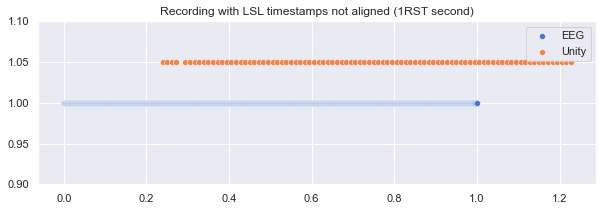

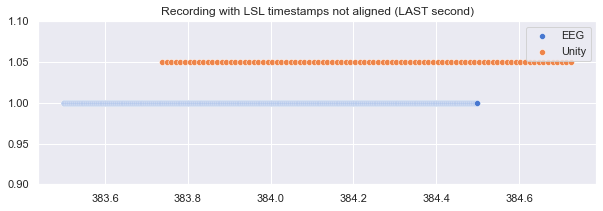

In [35]:
%matplotlib inline
sns.set_style("darkgrid")  # set seaborn plotting style
palette = itertools.cycle(sns.color_palette(palette="muted"))
plt.figure(figsize=(10, 3))
plt.title("Recording with LSL timestamps not aligned (1RST second)")
ey = [1 for d in recordings[0]["eeg"]["timestamps"][:1024]]
uy = [1.05 for d in recordings[0]["unity"]["timestamps"][:90]]
sns.scatterplot(x=recordings[0]["eeg"]["timestamps"][:1024], y=ey, color=next(palette))
sns.scatterplot(x=recordings[0]["unity"]["timestamps"][:90], y=uy, color=next(palette))
plt.ylim(0.9, 1.1)
plt.legend(["EEG", "Unity"])
plt.show()

sns.set_style("darkgrid")  # set seaborn plotting style
palette = itertools.cycle(sns.color_palette(palette="muted"))
plt.figure(figsize=(10, 3))
plt.title("Recording with LSL timestamps not aligned (LAST second)")
ey = [1 for d in recordings[2]["eeg"]["timestamps"][-1024:]]
uy = [1.05 for d in recordings[2]["unity"]["timestamps"][-90:]]
sns.scatterplot(x=recordings[2]["eeg"]["timestamps"][-1024:], y=ey, color=next(palette))
sns.scatterplot(x=recordings[2]["unity"]["timestamps"][-90:], y=uy, color=next(palette))
plt.ylim(0.9, 1.1)
plt.legend(["EEG", "Unity"])
plt.show()


In [111]:
stats = pd.DataFrame()  # create empty dataframe
for k in recordings:
    comparison = {}
    file = recordings[k]["file"].split(".")[0]  # remove extension from filename
    o_c = {"time_stamps": "O", "timestamps": "C"}
    for key in list(o_c.keys()):  # avoid duplicate code with different keys
        # for original and corrected timestamps
        u_ts = recordings[k]["unity"][key]
        e_ts = recordings[k]["eeg"][key]
        u_first = u_ts[0]
        u_last = u_ts[-1]
        e_first = e_ts[0]
        e_last = e_ts[-1]
        u_length = u_last - u_first
        e_length = e_last - e_first

        val = o_c[key]

        comparison[f"First EEG ({val})"] = e_first
        comparison[f"First Unity ({val})"] = u_first
        comparison[f"Last EEG ({val})"] = e_last
        comparison[f"Last Unity ({val})"] = u_last
        comparison[f"Length EEG ({val})"] = e_length
        comparison[f"Length Unity ({val})"] = u_length
        comparison[f"Sample count EEG ({val})"] = len(e_ts)
        comparison[f"Sample count Unity ({val})"] = len(u_ts)
        comparison[f"Start diff ({val})"] = u_first - e_first
        comparison[f"End diff ({val})"] = e_last - u_last
        comparison[f"Length diff ({val})"] = abs(u_length - e_length)

    # file info
    u_info = recordings[k]["unity"]["info"]
    e_info = recordings[k]["eeg"]["info"]
    i_u_first = u_info["first_timestamp"]
    i_u_last = u_info["last_timestamp"]
    i_e_first = e_info["first_timestamp"]
    i_e_last = e_info["last_timestamp"]
    i_e_length = float(i_e_last) - float(i_e_first)
    i_u_length = float(i_u_last) - float(i_u_first)

    comparison["First EEG (I)"] = i_e_first
    comparison["First Unity (I)"] = i_u_first
    comparison["Last EEG (I)"] = i_e_last
    comparison["Last Unity (I)"] = i_u_last
    comparison["Length EEG (I)"] = i_e_length
    comparison["Length Unity (I)"] = i_u_length
    comparison["Sample count EEG (I)"] = e_info["sample_count"]
    comparison["Sample count Unity (I)"] = u_info["sample_count"]
    comparison["Start diff (I)"] = float(i_u_first) - float(i_e_first)
    comparison[f"End diff ({val})"] = float(i_e_last) - float(i_u_last)
    comparison["Length diff (I)"] = abs(i_u_length - i_e_length)
    comparison["Stream creation (EEG)"] = e_info["created_at"]
    comparison["Stream creation (Unity)"] = u_info["created_at"]

    # order keys alphabetically
    comparison = dict(sorted(comparison.items()))
    current = pd.DataFrame.from_dict(
        comparison, orient="index", columns=[file], dtype=float
    )
    if stats.empty:  # first file
        stats = current
    else:
        stats = pd.merge(stats, current, left_index=True, right_index=True)

display(stats)

,lsl_try1,lsl_try2,lsl_try3,lsl_try4,lsl_try5
End diff (C),63103.61722,63103.54232,63103.52932,63103.50749,63103.53955
End diff (O),-0.19655,-0.27847,-0.29238,-0.32272,-0.29800
First EEG (C),0.00000,0.00000,0.00000,0.00000,0.00000
First EEG (I),659448.27446,662129.62898,662806.97281,665431.97590,669281.61128
First EEG (O),596344.46105,599025.80956,599703.15183,602328.14921,606177.77967
First Unity (C),0.23510,0.27995,0.29825,0.28808,0.23394
First Unity (I),596344.69616,599026.08951,599703.45008,602328.43730,606178.01361
First Unity (O),596344.69616,599026.08951,599703.45008,602328.43730,606178.01361
Last EEG (C),166.02989,622.99765,360.99829,1920.46413,3823.43046
Last EEG (I),659614.30473,662752.62800,663167.97183,667352.44356,673105.04769


In [112]:
# collect indexes (rows) containing "diff" to display and calculate the AVG
diff_indexes = [index for index in stats.index if "diff" in index]
diffs = stats.loc[diff_indexes]
diffs_mean = pd.DataFrame(diffs.mean(axis=1), columns=["AVG"])
diffs = pd.merge(diffs, diffs_mean, left_index=True, right_index=True)
display(diffs.style.applymap(color_checks, subset=["AVG"]))

,lsl_try1,lsl_try2,lsl_try3,lsl_try4,lsl_try5,AVG
End diff (C),63103.617223,63103.542324,63103.529322,63103.507490,63103.539547,63103.547181
End diff (O),-0.196554,-0.278466,-0.292383,-0.322721,-0.298004,-0.277626
Length diff (C),0.038547,0.001485,0.005863,0.034637,0.064065,0.028919
Length diff (I),0.038931,0.002858,0.006591,0.031111,0.058119,0.027522
Length diff (O),0.038547,0.001485,0.005863,0.034637,0.064065,0.028919
Start diff (C),0.235101,0.279951,0.298246,0.288084,0.233939,0.267064
Start diff (I),-63103.578292,-63103.539466,-63103.522731,-63103.538600,-63103.597666,-63103.555351
Start diff (O),0.235101,0.279951,0.298246,0.288084,0.233939,0.267064


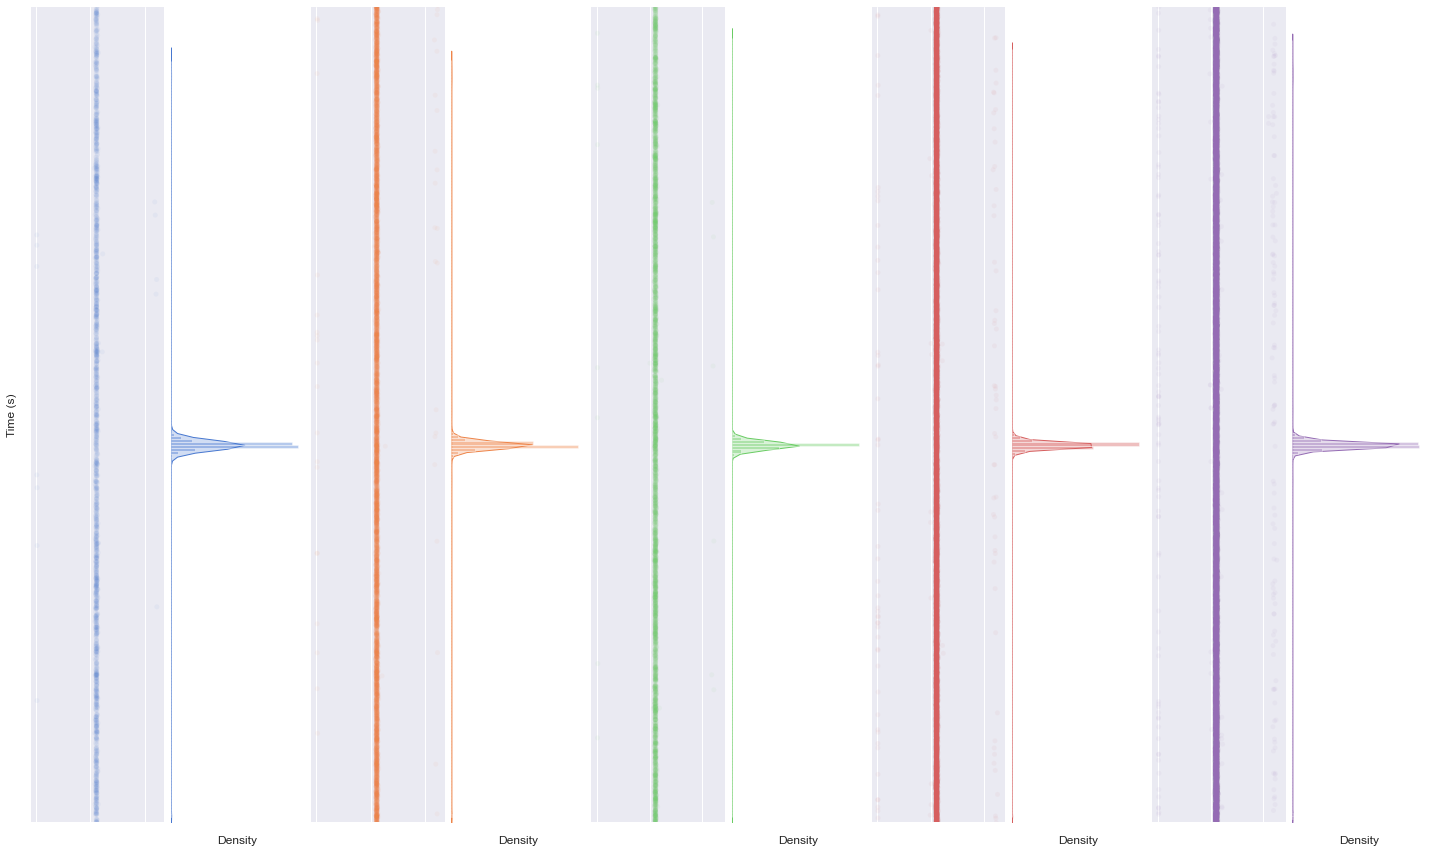

In [93]:
%matplotlib inline
nplots = len(u_dist) * 2  # number of subplots
palette = itertools.cycle(sns.color_palette(palette="muted"))

# define subplots
fig = plt.figure(figsize=(25, 15))
cols = 1
gs = fig.add_gridspec(cols, nplots)

y_max = 0
# since sharey does not work in this context by adding subplots one by one
for dist in u_dist:  # get the maximum y value to set the same scale on subplots
    if max(dist) > y_max:
        y_max = max(dist)

step = 0.001
ticks = np.arange(0, y_max + step, step)

kde = {"shade": True}
j = 0
for i in range(nplots):
    style = "darkgrid" if i % 2 == 0 else "white"
    with sns.axes_style(style):
        ax = fig.add_subplot(gs[i])
        if i % 2 == 0:
            color = next(palette)
            sns.stripplot(x=u_dist[j], ax=ax, orient="v", color=color, alpha=0.05)
            ax.set_xticklabels([files[j]])  # filename
            ax.set_ylim(0, y_max)
            ax.set_yticks(ticks)
        else:
            sns.distplot(
                u_dist[j],
                ax=ax,
                vertical=True,
                norm_hist=True,
                bins=250,
                kde_kws=kde,
                color=color,
            )
            ax.set_ylim(0, y_max)
            ax.set_yticks(ticks)
            ax.set_xticklabels([])
            sns.despine(left=True, bottom=True)
            j += 1
        if i != 0:
            ax.set_yticklabels([])


plt.subplots_adjust(wspace=0.05)
fig.axes[0].set_ylabel("Time (s)")
plt.show()